In [3]:
# Cell 1: Install required packages
!pip install -q torch torchvision
!pip install -q timm  # PyTorch Image Models - contains optimized ViT implementations
!pip install -q matplotlib numpy tqdm

In [4]:
# Cell 2: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [5]:
# Cell 3: Define Vision Transformer Architecture
class PatchEmbedding(nn.Module):
    """Convert image into patches and embed them"""
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Patchify using convolution
        self.proj = nn.Conv2d(in_channels, embed_dim,
                             kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x


class MultiHeadSelfAttention(nn.Module):
    """Multi-Head Self-Attention mechanism"""
    def __init__(self, embed_dim=256, num_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        return x


class MLP(nn.Module):
    """MLP block with GELU activation"""
    def __init__(self, embed_dim=256, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class TransformerEncoderBlock(nn.Module):
    """Transformer Encoder Block with MHSA + MLP + Residual + LayerNorm"""
    def __init__(self, embed_dim=256, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_ratio, dropout)

    def forward(self, x):
        # MHSA with residual
        x = x + self.attn(self.norm1(x))
        # MLP with residual
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformer(nn.Module):
    """Complete Vision Transformer for CIFAR-10"""
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        n_patches = self.patch_embed.n_patches

        # CLS token (learnable)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embeddings (learnable)
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.pos_dropout = nn.Dropout(dropout)

        # Transformer encoder blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        B = x.shape[0]

        # Patch embedding
        x = self.patch_embed(x)  # (B, n_patches, embed_dim)

        # Prepend CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, n_patches+1, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_dropout(x)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Classification from CLS token
        x = self.norm(x)
        cls_token_final = x[:, 0]  # Take CLS token
        x = self.head(cls_token_final)

        return x


In [6]:
# Cell 4: Prepare CIFAR-10 dataset with augmentation
def get_cifar10_dataloaders(batch_size=128):
    """Load CIFAR-10 with strong data augmentation"""

    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                           std=[0.2470, 0.2435, 0.2616]),
        transforms.RandomErasing(p=0.25)  # Cutout-like augmentation
    ])

    # Test transforms (no augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                           std=[0.2470, 0.2435, 0.2616])
    ])

    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2, pin_memory=True)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return train_loader, test_loader

# Load data
train_loader, test_loader = get_cifar10_dataloaders(batch_size=128)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [02:49<00:00, 1.01MB/s]


Training samples: 50000
Test samples: 10000


In [7]:
# Cell 5: Training and evaluation functions
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.3f}',
                         'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    """Evaluate on test/validation set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [8]:
# Cell 6: Initialize model and training components
print("\n" + "="*60)
print("INITIALIZING VISION TRANSFORMER")
print("="*60)

# Model configuration (optimized for CIFAR-10)
model = VisionTransformer(
    img_size=32,
    patch_size=4,        # 4x4 patches -> 64 patches total
    in_channels=3,
    num_classes=10,
    embed_dim=256,       # Embedding dimension
    depth=6,             # 6 transformer blocks
    num_heads=8,         # 8 attention heads
    mlp_ratio=4.0,       # MLP hidden dim = 4 * embed_dim
    dropout=0.1
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)

# Learning rate scheduler (cosine annealing)
num_epochs = 100
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print(f"\nTraining configuration:")
print(f"  - Epochs: {num_epochs}")
print(f"  - Batch size: 128")
print(f"  - Initial LR: 3e-4")
print(f"  - Optimizer: AdamW (weight_decay=0.05)")
print(f"  - Scheduler: CosineAnnealingLR")
print(f"  - Augmentation: RandomCrop, HFlip, ColorJitter, Rotation, RandomErasing")



INITIALIZING VISION TRANSFORMER

Total parameters: 4,771,082
Trainable parameters: 4,771,082

Training configuration:
  - Epochs: 100
  - Batch size: 128
  - Initial LR: 3e-4
  - Optimizer: AdamW (weight_decay=0.05)
  - Scheduler: CosineAnnealingLR
  - Augmentation: RandomCrop, HFlip, ColorJitter, Rotation, RandomErasing


In [9]:
# Cell 6: Initialize model and training components
print("\n" + "="*60)
print("INITIALIZING VISION TRANSFORMER")
print("="*60)

# Model configuration (optimized for CIFAR-10 - faster training)
model = VisionTransformer(
    img_size=32,
    patch_size=4,        # 4x4 patches -> 64 patches total
    in_channels=3,
    num_classes=10,
    embed_dim=384,       # Increased from 256 to 384 for better capacity
    depth=7,             # 7 transformer blocks (slight increase)
    num_heads=6,         # 6 attention heads (384/6 = 64 per head)
    mlp_ratio=4.0,       # MLP hidden dim = 4 * embed_dim
    dropout=0.1
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss and optimizer with label smoothing for faster convergence
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)

# Learning rate scheduler with warmup + cosine decay
num_epochs = 50  # Reduced from 100 to 50 epochs
warmup_epochs = 5

def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs  # Linear warmup
    else:
        # Cosine decay after warmup
        progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        return 0.5 * (1 + np.cos(np.pi * progress))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

print(f"\nTraining configuration (FAST MODE):")
print(f"  - Epochs: {num_epochs} (50% reduction)")
print(f"  - Batch size: 128")
print(f"  - Initial LR: 1e-3 (higher for faster convergence)")
print(f"  - Warmup epochs: {warmup_epochs}")
print(f"  - Optimizer: AdamW (weight_decay=0.05)")
print(f"  - Scheduler: Warmup + CosineAnnealingLR")
print(f"  - Label Smoothing: 0.1 (regularization)")
print(f"  - Augmentation: RandomCrop, HFlip, ColorJitter, Rotation, RandomErasing")



INITIALIZING VISION TRANSFORMER

Total parameters: 12,470,026
Trainable parameters: 12,470,026

Training configuration (FAST MODE):
  - Epochs: 50 (50% reduction)
  - Batch size: 128
  - Initial LR: 1e-3 (higher for faster convergence)
  - Warmup epochs: 5
  - Optimizer: AdamW (weight_decay=0.05)
  - Scheduler: Warmup + CosineAnnealingLR
  - Label Smoothing: 0.1 (regularization)
  - Augmentation: RandomCrop, HFlip, ColorJitter, Rotation, RandomErasing


In [10]:
# Cell 7: Training loop
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

history = {
    'train_loss': [], 'train_acc': [],
    'test_loss': [], 'test_acc': []
}

best_test_acc = 0.0
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_vit_cifar10.pth')
        print(f"  ✓ New best test accuracy: {best_test_acc:.2f}%")

total_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"TRAINING COMPLETED!")
print(f"{'='*60}")
print(f"Total training time: {total_time/60:.2f} minutes")
print(f"Best test accuracy: {best_test_acc:.2f}%")



STARTING TRAINING


Epoch 1/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 13.65it/s]



Epoch 1 Summary:
  Train Loss: 1.9674 | Train Acc: 29.45%
  Test Loss:  1.8386 | Test Acc:  36.04%
  Learning Rate: 0.000400
  ✓ New best test accuracy: 36.04%

Epoch 2/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 13.08it/s]



Epoch 2 Summary:
  Train Loss: 1.7935 | Train Acc: 39.00%
  Test Loss:  1.6876 | Test Acc:  45.17%
  Learning Rate: 0.000600
  ✓ New best test accuracy: 45.17%

Epoch 3/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.66it/s]



Epoch 3 Summary:
  Train Loss: 1.7332 | Train Acc: 42.38%
  Test Loss:  1.6353 | Test Acc:  47.71%
  Learning Rate: 0.000800
  ✓ New best test accuracy: 47.71%

Epoch 4/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.56it/s]



Epoch 4 Summary:
  Train Loss: 1.7308 | Train Acc: 42.27%
  Test Loss:  1.6304 | Test Acc:  47.21%
  Learning Rate: 0.001000

Epoch 5/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.63it/s]



Epoch 5 Summary:
  Train Loss: 1.7511 | Train Acc: 41.69%
  Test Loss:  1.6536 | Test Acc:  46.76%
  Learning Rate: 0.001000

Epoch 6/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.62it/s]



Epoch 6 Summary:
  Train Loss: 1.7341 | Train Acc: 42.00%
  Test Loss:  1.6457 | Test Acc:  46.82%
  Learning Rate: 0.000999

Epoch 7/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.67it/s]



Epoch 7 Summary:
  Train Loss: 1.7350 | Train Acc: 42.26%
  Test Loss:  1.6315 | Test Acc:  48.00%
  Learning Rate: 0.000995
  ✓ New best test accuracy: 48.00%

Epoch 8/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.58it/s]



Epoch 8 Summary:
  Train Loss: 1.6954 | Train Acc: 44.26%
  Test Loss:  1.5773 | Test Acc:  49.31%
  Learning Rate: 0.000989
  ✓ New best test accuracy: 49.31%

Epoch 9/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.49it/s]



Epoch 9 Summary:
  Train Loss: 1.6653 | Train Acc: 45.75%
  Test Loss:  1.5513 | Test Acc:  50.78%
  Learning Rate: 0.000981
  ✓ New best test accuracy: 50.78%

Epoch 10/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.67it/s]



Epoch 10 Summary:
  Train Loss: 1.6535 | Train Acc: 46.29%
  Test Loss:  1.5652 | Test Acc:  51.12%
  Learning Rate: 0.000970
  ✓ New best test accuracy: 51.12%

Epoch 11/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.64it/s]



Epoch 11 Summary:
  Train Loss: 1.6388 | Train Acc: 46.89%
  Test Loss:  1.5367 | Test Acc:  51.86%
  Learning Rate: 0.000957
  ✓ New best test accuracy: 51.86%

Epoch 12/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.62it/s]



Epoch 12 Summary:
  Train Loss: 1.6195 | Train Acc: 48.00%
  Test Loss:  1.5203 | Test Acc:  52.70%
  Learning Rate: 0.000941
  ✓ New best test accuracy: 52.70%

Epoch 13/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]



Epoch 13 Summary:
  Train Loss: 1.6065 | Train Acc: 48.60%
  Test Loss:  1.5236 | Test Acc:  52.86%
  Learning Rate: 0.000924
  ✓ New best test accuracy: 52.86%

Epoch 14/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.70it/s]



Epoch 14 Summary:
  Train Loss: 1.5973 | Train Acc: 48.75%
  Test Loss:  1.4867 | Test Acc:  54.21%
  Learning Rate: 0.000905
  ✓ New best test accuracy: 54.21%

Epoch 15/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.54it/s]



Epoch 15 Summary:
  Train Loss: 1.5866 | Train Acc: 49.50%
  Test Loss:  1.4615 | Test Acc:  55.53%
  Learning Rate: 0.000883
  ✓ New best test accuracy: 55.53%

Epoch 16/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.59it/s]



Epoch 16 Summary:
  Train Loss: 1.5665 | Train Acc: 50.46%
  Test Loss:  1.4835 | Test Acc:  54.73%
  Learning Rate: 0.000860

Epoch 17/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.62it/s]



Epoch 17 Summary:
  Train Loss: 1.5491 | Train Acc: 51.47%
  Test Loss:  1.4343 | Test Acc:  56.33%
  Learning Rate: 0.000835
  ✓ New best test accuracy: 56.33%

Epoch 18/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.68it/s]



Epoch 18 Summary:
  Train Loss: 1.5349 | Train Acc: 52.08%
  Test Loss:  1.4319 | Test Acc:  56.06%
  Learning Rate: 0.000808

Epoch 19/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]



Epoch 19 Summary:
  Train Loss: 1.5167 | Train Acc: 52.64%
  Test Loss:  1.4071 | Test Acc:  58.13%
  Learning Rate: 0.000780
  ✓ New best test accuracy: 58.13%

Epoch 20/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.65it/s]



Epoch 20 Summary:
  Train Loss: 1.5094 | Train Acc: 53.18%
  Test Loss:  1.4038 | Test Acc:  57.92%
  Learning Rate: 0.000750

Epoch 21/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.59it/s]



Epoch 21 Summary:
  Train Loss: 1.4897 | Train Acc: 54.07%
  Test Loss:  1.3917 | Test Acc:  59.13%
  Learning Rate: 0.000719
  ✓ New best test accuracy: 59.13%

Epoch 22/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.66it/s]



Epoch 22 Summary:
  Train Loss: 1.4743 | Train Acc: 54.97%
  Test Loss:  1.3632 | Test Acc:  59.44%
  Learning Rate: 0.000687
  ✓ New best test accuracy: 59.44%

Epoch 23/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.39it/s]



Epoch 23 Summary:
  Train Loss: 1.4567 | Train Acc: 55.50%
  Test Loss:  1.3491 | Test Acc:  60.55%
  Learning Rate: 0.000655
  ✓ New best test accuracy: 60.55%

Epoch 24/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.59it/s]



Epoch 24 Summary:
  Train Loss: 1.4417 | Train Acc: 56.29%
  Test Loss:  1.3820 | Test Acc:  59.39%
  Learning Rate: 0.000621

Epoch 25/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.64it/s]



Epoch 25 Summary:
  Train Loss: 1.4281 | Train Acc: 57.08%
  Test Loss:  1.3371 | Test Acc:  61.30%
  Learning Rate: 0.000587
  ✓ New best test accuracy: 61.30%

Epoch 26/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.58it/s]



Epoch 26 Summary:
  Train Loss: 1.4098 | Train Acc: 58.20%
  Test Loss:  1.3096 | Test Acc:  62.43%
  Learning Rate: 0.000552
  ✓ New best test accuracy: 62.43%

Epoch 27/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.63it/s]



Epoch 27 Summary:
  Train Loss: 1.3910 | Train Acc: 58.93%
  Test Loss:  1.2917 | Test Acc:  62.97%
  Learning Rate: 0.000517
  ✓ New best test accuracy: 62.97%

Epoch 28/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]



Epoch 28 Summary:
  Train Loss: 1.3742 | Train Acc: 59.95%
  Test Loss:  1.2828 | Test Acc:  64.23%
  Learning Rate: 0.000483
  ✓ New best test accuracy: 64.23%

Epoch 29/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.62it/s]



Epoch 29 Summary:
  Train Loss: 1.3522 | Train Acc: 60.73%
  Test Loss:  1.2546 | Test Acc:  65.17%
  Learning Rate: 0.000448
  ✓ New best test accuracy: 65.17%

Epoch 30/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.63it/s]



Epoch 30 Summary:
  Train Loss: 1.3360 | Train Acc: 61.44%
  Test Loss:  1.2489 | Test Acc:  65.79%
  Learning Rate: 0.000413
  ✓ New best test accuracy: 65.79%

Epoch 31/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.50it/s]



Epoch 31 Summary:
  Train Loss: 1.3204 | Train Acc: 62.26%
  Test Loss:  1.2158 | Test Acc:  66.77%
  Learning Rate: 0.000379
  ✓ New best test accuracy: 66.77%

Epoch 32/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.44it/s]



Epoch 32 Summary:
  Train Loss: 1.2998 | Train Acc: 63.23%
  Test Loss:  1.1906 | Test Acc:  68.68%
  Learning Rate: 0.000345
  ✓ New best test accuracy: 68.68%

Epoch 33/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.46it/s]



Epoch 33 Summary:
  Train Loss: 1.2854 | Train Acc: 64.07%
  Test Loss:  1.1873 | Test Acc:  68.19%
  Learning Rate: 0.000313

Epoch 34/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.62it/s]



Epoch 34 Summary:
  Train Loss: 1.2689 | Train Acc: 64.59%
  Test Loss:  1.1795 | Test Acc:  68.61%
  Learning Rate: 0.000281

Epoch 35/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]



Epoch 35 Summary:
  Train Loss: 1.2505 | Train Acc: 65.70%
  Test Loss:  1.1861 | Test Acc:  68.37%
  Learning Rate: 0.000250

Epoch 36/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.56it/s]



Epoch 36 Summary:
  Train Loss: 1.2336 | Train Acc: 66.32%
  Test Loss:  1.1703 | Test Acc:  69.69%
  Learning Rate: 0.000220
  ✓ New best test accuracy: 69.69%

Epoch 37/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.60it/s]



Epoch 37 Summary:
  Train Loss: 1.2221 | Train Acc: 66.89%
  Test Loss:  1.1435 | Test Acc:  70.75%
  Learning Rate: 0.000192
  ✓ New best test accuracy: 70.75%

Epoch 38/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.54it/s]



Epoch 38 Summary:
  Train Loss: 1.2047 | Train Acc: 67.96%
  Test Loss:  1.1359 | Test Acc:  70.94%
  Learning Rate: 0.000165
  ✓ New best test accuracy: 70.94%

Epoch 39/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.45it/s]



Epoch 39 Summary:
  Train Loss: 1.1933 | Train Acc: 68.35%
  Test Loss:  1.1317 | Test Acc:  70.86%
  Learning Rate: 0.000140

Epoch 40/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.67it/s]



Epoch 40 Summary:
  Train Loss: 1.1756 | Train Acc: 69.30%
  Test Loss:  1.1185 | Test Acc:  71.86%
  Learning Rate: 0.000117
  ✓ New best test accuracy: 71.86%

Epoch 41/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]



Epoch 41 Summary:
  Train Loss: 1.1651 | Train Acc: 69.65%
  Test Loss:  1.1103 | Test Acc:  72.29%
  Learning Rate: 0.000095
  ✓ New best test accuracy: 72.29%

Epoch 42/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.56it/s]



Epoch 42 Summary:
  Train Loss: 1.1550 | Train Acc: 70.22%
  Test Loss:  1.1101 | Test Acc:  72.53%
  Learning Rate: 0.000076
  ✓ New best test accuracy: 72.53%

Epoch 43/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.63it/s]



Epoch 43 Summary:
  Train Loss: 1.1427 | Train Acc: 70.61%
  Test Loss:  1.1080 | Test Acc:  72.31%
  Learning Rate: 0.000059

Epoch 44/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.63it/s]



Epoch 44 Summary:
  Train Loss: 1.1348 | Train Acc: 71.01%
  Test Loss:  1.0948 | Test Acc:  72.77%
  Learning Rate: 0.000043
  ✓ New best test accuracy: 72.77%

Epoch 45/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.38it/s]



Epoch 45 Summary:
  Train Loss: 1.1282 | Train Acc: 71.23%
  Test Loss:  1.0970 | Test Acc:  72.52%
  Learning Rate: 0.000030

Epoch 46/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.56it/s]



Epoch 46 Summary:
  Train Loss: 1.1246 | Train Acc: 71.37%
  Test Loss:  1.0922 | Test Acc:  73.11%
  Learning Rate: 0.000019
  ✓ New best test accuracy: 73.11%

Epoch 47/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.60it/s]



Epoch 47 Summary:
  Train Loss: 1.1177 | Train Acc: 71.80%
  Test Loss:  1.0899 | Test Acc:  73.29%
  Learning Rate: 0.000011
  ✓ New best test accuracy: 73.29%

Epoch 48/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.59it/s]



Epoch 48 Summary:
  Train Loss: 1.1130 | Train Acc: 72.12%
  Test Loss:  1.0864 | Test Acc:  73.35%
  Learning Rate: 0.000005
  ✓ New best test accuracy: 73.35%

Epoch 49/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.59it/s]



Epoch 49 Summary:
  Train Loss: 1.1102 | Train Acc: 72.32%
  Test Loss:  1.0886 | Test Acc:  73.22%
  Learning Rate: 0.000001

Epoch 50/50
----------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.64it/s]


Epoch 50 Summary:
  Train Loss: 1.1100 | Train Acc: 72.01%
  Test Loss:  1.0873 | Test Acc:  73.20%
  Learning Rate: 0.000000

TRAINING COMPLETED!
Total training time: 83.39 minutes
Best test accuracy: 73.35%


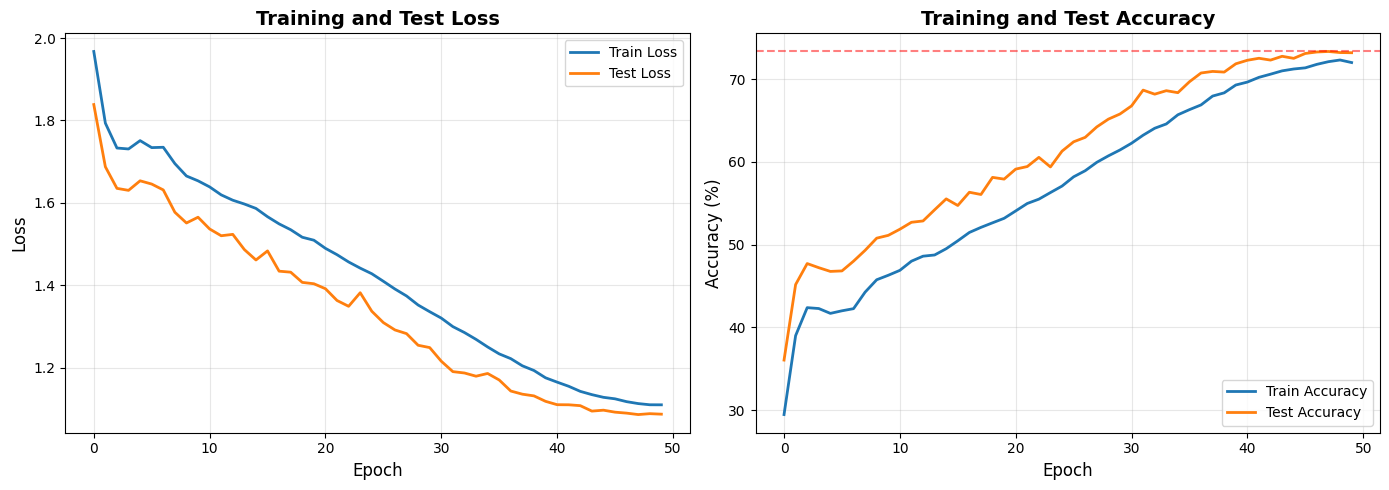

In [11]:
# Cell 8: Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['test_loss'], label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Test Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['test_acc'], label='Test Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=best_test_acc, color='r', linestyle='--', alpha=0.5,
               label=f'Best: {best_test_acc:.2f}%')

plt.tight_layout()
plt.savefig('vit_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
 # Cell 9: Final results summary
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nModel Architecture:")
print(f"  - Patch Size: 4x4")
print(f"  - Number of Patches: 64")
print(f"  - Embedding Dimension: 256")
print(f"  - Transformer Depth: 6 blocks")
print(f"  - Attention Heads: 8")
print(f"  - Total Parameters: {total_params:,}")

print(f"\nPerformance:")
print(f"  - Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"  - Final Test Accuracy:  {history['test_acc'][-1]:.2f}%")
print(f"  - Best Test Accuracy:   {best_test_acc:.2f}%")
print(f"  - Training Time: {total_time/60:.2f} minutes")

print(f"\n{'='*60}")


FINAL RESULTS SUMMARY

Model Architecture:
  - Patch Size: 4x4
  - Number of Patches: 64
  - Embedding Dimension: 256
  - Transformer Depth: 6 blocks
  - Attention Heads: 8
  - Total Parameters: 12,470,026

Performance:
  - Final Train Accuracy: 72.01%
  - Final Test Accuracy:  73.20%
  - Best Test Accuracy:   73.35%
  - Training Time: 83.39 minutes



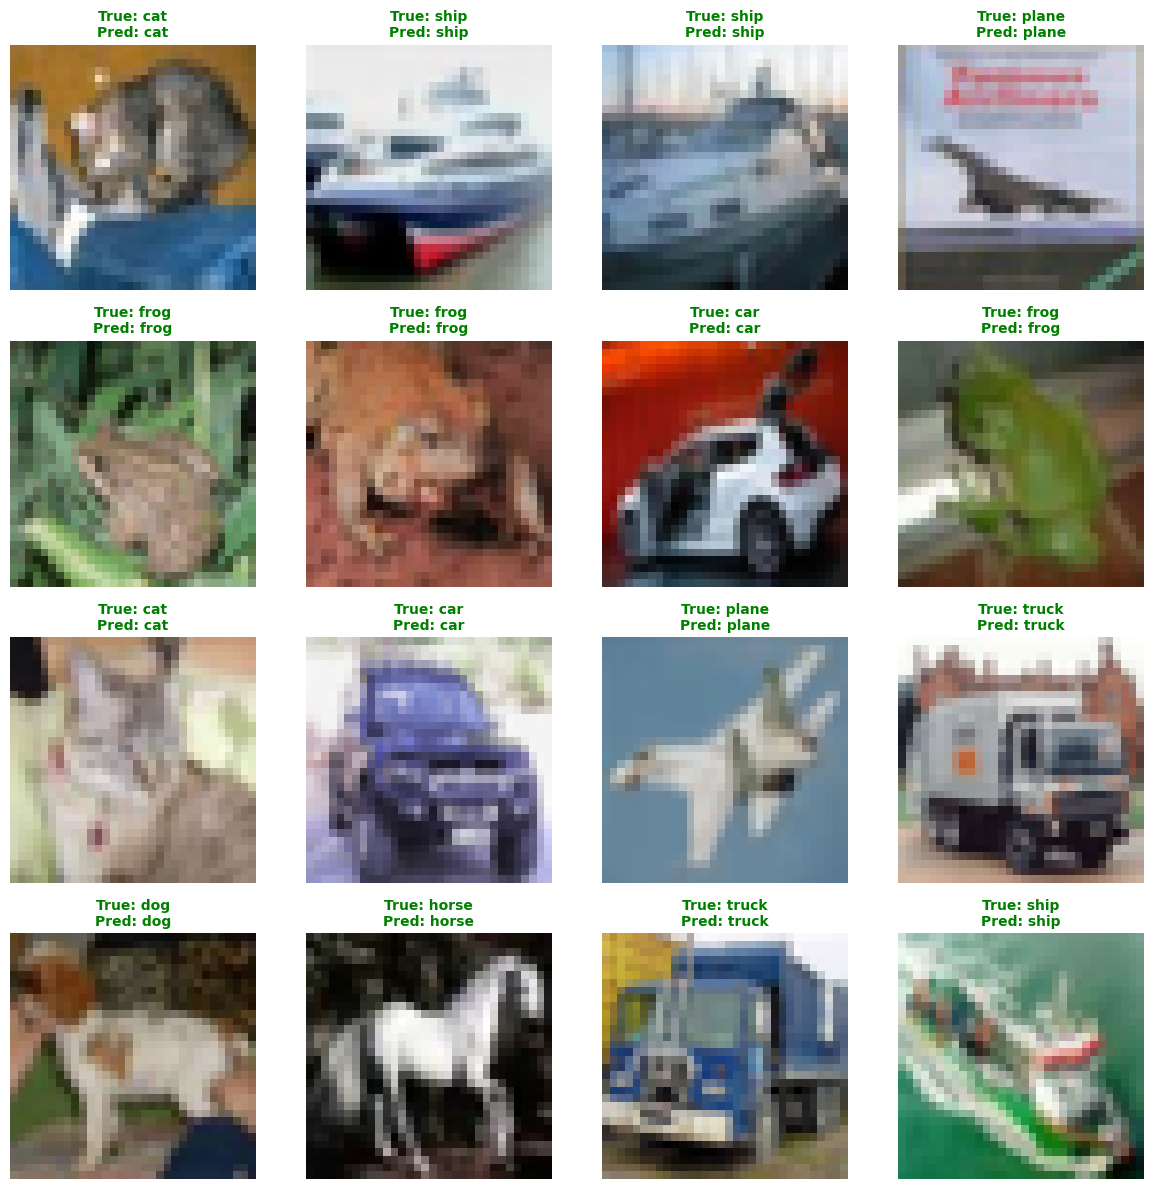

In [15]:
 # Cell 10: Test on sample images
def visualize_predictions(model, test_loader, device, num_images=16):
    """Visualize model predictions on sample images"""
    model.eval()

    # Get one batch
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Move to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    # Denormalize images
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)

    # Plot
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for idx in range(min(num_images, len(images))):
        ax = axes[idx // 4, idx % 4]
        img = images[idx].permute(1, 2, 0).numpy()
        ax.imshow(img)

        true_label = classes[labels[idx]]
        pred_label = classes[predicted[idx]]
        color = 'green' if labels[idx] == predicted[idx] else 'red'

        ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                    color=color, fontsize=10, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('vit_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_predictions(model, test_loader, device)